# Estimation of daily damage by a warrior

### Necessary imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import seaborn as sn

## Game mechanics

### Critical modifier

In [2]:
base_critical = 0.03
critical_chance = lambda s: base_critical * (1 + s/100)
critical_multiplier = lambda s: 1.5 + 4 * s / (s + 200)
critical_modifier = lambda s: 1 + critical_multiplier(s) * critical_chance(s)

### Base damage

In [3]:
s_modifier = lambda s: 1 + s * 0.005
base_damage = lambda s, task_base: critical_modifier(s) * s_modifier(s) * pow(0.9747, task_base)
base_damage_tb0 = lambda s: base_damage(s, 0)

### Brutal Smash

In [4]:
brutal_smash_damage = lambda s: 55 * s / (s + 70)
mana_cost = 10

mana = lambda i: 2 * i + 30
mana_per_task = lambda i, s: max(100, mana(i)) / 100 * critical_modifier(s)

brutal_smash_per_task = lambda i, s: brutal_smash_damage(s) / mana_cost * mana_per_task(i, s) * critical_modifier(s)

### Total Damage

In [5]:
total_damage_per_task = lambda i, s: base_damage_tb0(s) + brutal_smash_per_task(i, s)

def brutal_smash_per_day(i, s, mana_regen_per_day):
    return brutal_smash_damage(s) / mana_cost * mana(i) * mana_regen_per_day * critical_modifier(s)

def total_damage_per_day(i, s, tasks_completed_per_day, total_tasks):
    perfect_day_mana_regen_cap = 0.1
    mana_regen_per_day = tasks_completed_per_day / total_tasks * perfect_day_mana_regen_cap
    return total_damage_per_task(i, s) * tasks_completed_per_day + brutal_smash_per_day(i, s, mana_regen_per_day)

## Example

In [6]:
tasks_per_day = 8
total_tasks = 10

print(total_damage_per_day(159, 87, tasks_per_day, total_tasks))
print(total_damage_per_day(159+14, 87, tasks_per_day, total_tasks))
print(total_damage_per_day(159, 87+14, tasks_per_day, total_tasks))

223.62746698494595
240.5562438917807
244.1381009196958


# Search for best int/str

In [7]:
level = 100
tasks_per_day = 8
total_tasks = 10

### Creating Search

In [8]:
max_from_gear = 120
grid = int(level/2), 3/2 * level + max_from_gear, 1
intel = np.arange(*grid)
stren = np.arange(*grid)

damage = np.zeros(shape=(len(intel), len(stren)))
for i in range(len(intel)):
    for s in range(len(stren)):
        damage[i, s] = total_damage_per_day(intel[i], stren[s], tasks_per_day, total_tasks)

### Damage plot

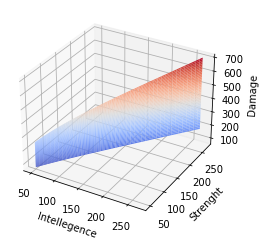

In [9]:
ax = plt.axes(projection="3d")
ax.plot_surface(intel, stren, damage, cmap=cm.coolwarm, )
ax.set_xlabel('Intellegence')
ax.set_ylabel('Strenght')
ax.set_zlabel('Damage')

plt.show()

## General trend

Int=58.0	Str=52.0	Ratio=1.12
Int=64.0	Str=56.0	Ratio=1.14
Int=71.0	Str=59.0	Ratio=1.20
Int=77.0	Str=63.0	Ratio=1.22
Int=84.0	Str=66.0	Ratio=1.27
Int=90.0	Str=70.0	Ratio=1.29
Int=97.0	Str=73.0	Ratio=1.33
Int=103.0	Str=77.0	Ratio=1.34
Int=110.0	Str=80.0	Ratio=1.38
Int=116.0	Str=84.0	Ratio=1.38
Int=123.0	Str=87.0	Ratio=1.41
Int=129.0	Str=91.0	Ratio=1.42
Int=135.0	Str=95.0	Ratio=1.42
Int=142.0	Str=98.0	Ratio=1.45
Int=148.0	Str=102.0	Ratio=1.45
Int=155.0	Str=105.0	Ratio=1.48
Int=161.0	Str=109.0	Ratio=1.48
Int=167.0	Str=113.0	Ratio=1.48
Int=174.0	Str=116.0	Ratio=1.50
Int=180.0	Str=120.0	Ratio=1.50
Int=186.0	Str=124.0	Ratio=1.50
Int=192.0	Str=127.0	Ratio=1.51


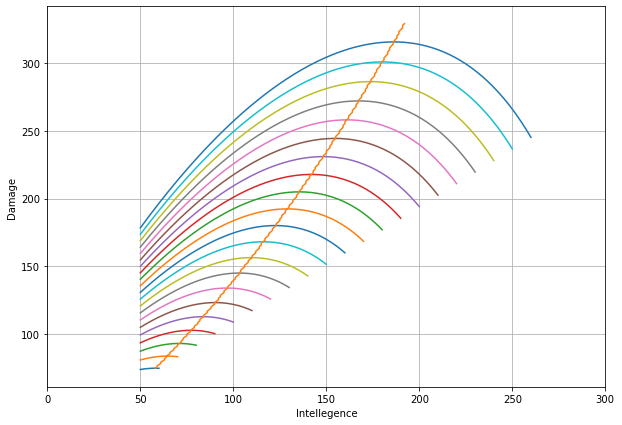

In [10]:
allocate = lambda x, r: r - x

plt.figure(figsize=(10, 7))
r = min(damage.shape) - 1
best_line_i = []
best_line_d = []
for r in range(10, min(damage.shape), 1):
    damage_ring = []
    for i in range(r+1):
        damage_ring.append(damage[i, allocate(i, r)])

    best_line_i.append(np.argmax(damage_ring))
    best_line_d.append(max(damage_ring))
    
    if r%10 == 0: 
        plt.plot(damage_ring)
        best_i = intel[np.argmax(damage_ring)]
        best_s = stren[r - np.argmax(damage_ring)]
        print(f"Int={best_i}\tStr={best_s}\tRatio={best_i/best_s:.2f}")
    
plt.plot(best_line_i, best_line_d)
plt.grid()
plt.xlabel("Intellegence")
plt.ylabel("Damage")
plt.xticks(ticks= plt.xticks()[0], labels = map(int, plt.xticks()[0] + min(intel)))
best_i = intel[np.argmax(damage_ring)]
best_s = stren[r - np.argmax(damage_ring)]
print(f"Int={best_i}\tStr={best_s}\tRatio={best_i/best_s:.2f}")
pass

## Conclusion

Looks that optimum ratio b/w intellegence and strength is approaching 1.5 at initial 100 levels.

# Level progression

In [11]:
tasks_per_day = 8
total_tasks = 10
gear_int = 66  # best currently known gear for int
gear_str = 50  # best currently known gear for str
total_damage = lambda i, s: total_damage_per_day(i + gear_int, s + gear_str, tasks_per_day, total_tasks)

In [12]:
def get_best_allocation(base, pool, damage_func):
    best_i = 0
    best_d = 0
    for i in range(pool+1):
        damage = damage_func(base + i, base + pool - i)
        if damage > best_d:
            best_d = damage
            best_i = i
    return best_i, pool - best_i

In [15]:
perfect_days_ratio = .1

prev_best_i = 0
best = []
for level in range(10, 201):
    base = int(level / 2)
    base_with_boost = int(base + min(level / 2, 50) * perfect_days_ratio)
    pool = level
    best_i = get_best_allocation(base_with_boost, pool, total_damage)[0]
    best.append(best_i)
    if prev_best_i < best_i:
        print(f"{level:3}: allocate {best_i:3} to Int (+{best_i - prev_best_i}):\
              {best_i + base + gear_int} Int and {pool - best_i + base + gear_str} Str")
        prev_best_i = best_i

 10: allocate   4 to Int (+4):              75 Int and 61 Str
 12: allocate   5 to Int (+1):              77 Int and 63 Str
 13: allocate   6 to Int (+1):              78 Int and 63 Str
 14: allocate   7 to Int (+1):              80 Int and 64 Str
 15: allocate   8 to Int (+1):              81 Int and 64 Str
 17: allocate   9 to Int (+1):              83 Int and 66 Str
 18: allocate  10 to Int (+1):              85 Int and 67 Str
 19: allocate  11 to Int (+1):              86 Int and 67 Str
 20: allocate  12 to Int (+1):              88 Int and 68 Str
 21: allocate  13 to Int (+1):              89 Int and 68 Str
 22: allocate  14 to Int (+1):              91 Int and 69 Str
 24: allocate  15 to Int (+1):              93 Int and 71 Str
 25: allocate  16 to Int (+1):              94 Int and 71 Str
 26: allocate  17 to Int (+1):              96 Int and 72 Str
 28: allocate  18 to Int (+1):              98 Int and 74 Str
 29: allocate  19 to Int (+1):              99 Int and 74 Str
 30: all